# MT5 Trade Analysis

This notebook analyzes trading data exported from MetaTrader 5 (MT5) for the EUR/GBP currency pair. The data is loaded from the Excel file `deals eurgbp.xlsx`, located in the `/home/edocame/Desktop/data_python/` directory.


## Table of Contents

1. [Data Loading](#data-loading)

2. [Outlier Detection](#outlier-detection)

3. [Trade Duration Calculation](#trade-duration)

4. [Profit vs Duration Analysis](#profit-vs-duration)

5. [Profit Distribution by Duration](#profit-distribution)

6. [Profits/Losses by Duration Bin](#profits-losses-bin)

7. [Profits/Losses <= 500min](#profits-losses-500min)

8. [Profit/Loss Size <= 500min](#profit-loss-size-500min)


---


## Data Source

- **File:** `deals eurgbp.xlsx`

- **Origin:** Exported from MetaTrader 5 (MT5).

- **Instrument:** EUR/GBP

- **Date range**: 2024-11-01 00:05:00 to 2025-06-24 23:58:59


## Data Description

The dataset contains detailed trade records, including columns such as:

- `Time`: Timestamp of each trade event

- `Direction`: Trade direction (e.g., 'in' for entry, 'out' for exit)

- `Profit`: Profit or loss for each trade

- Other trade-related fields


## Notebook Purpose

The notebook explores the structure of the trading data, identifies outliers in trade profits using z-score analysis, and investigates the relationship between trade duration and profit. It includes data visualization and statistical analysis to better understand trading performance and patterns.

In [48]:
# 1. Data Loading

data_path = '/home/edocame/Desktop/data_python/deals eurgbp.xlsx'


import pandas as pd


# Leggi il file Excel usando pandas e openpyxl

df = pd.read_excel(data_path, engine='openpyxl')

df = df.iloc[1:].reset_index(drop=True)

df.head()

,Time,Deal,Symbol,Type,Direction,Volume,Price,Order,Commission,Swap,Profit,Balance,Comment
0,2024.11.01 00:05:00,2,EURGBP.sml,sell,in,0.1,0.84377,2.0,0,0,0.0,10000.0,BB Short Entry
1,2024.11.01 11:11:40,3,EURGBP.sml,buy,out,0.1,0.84199,3.0,0,0,17.8,10017.8,tp 0.84199
2,2024.11.01 15:09:00,4,EURGBP.sml,buy,in,0.1,0.84100,4.0,0,0,0.0,10017.8,BB Long Entry
3,2024.11.04 09:49:39,5,EURGBP.sml,sell,out,0.1,0.83940,5.0,0,0,-16.0,10001.8,tp 0.83940
4,2024.11.04 11:01:00,6,EURGBP.sml,sell,in,0.1,0.84046,6.0,0,0,0.0,10001.8,BB Short Entry


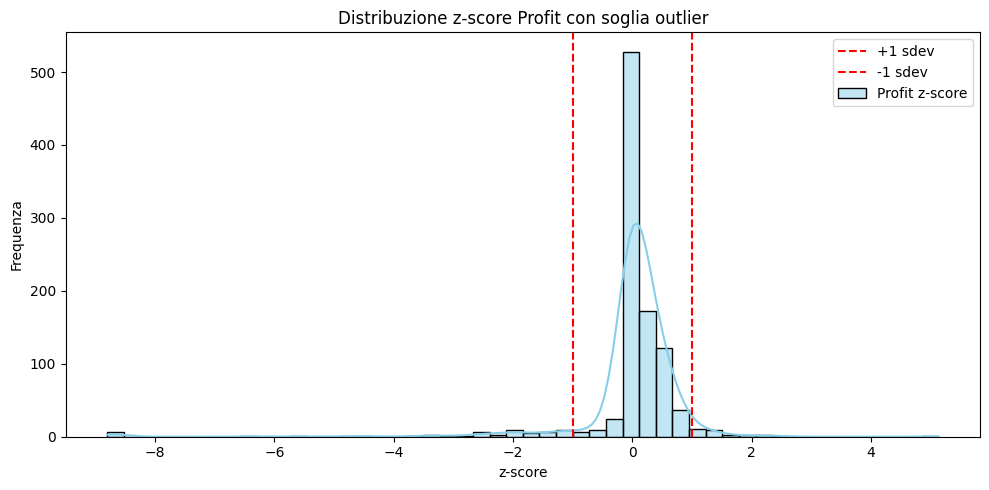

In [49]:
# 2. Outlier Detection

# Soglia z-score per determinare gli outlier
z_threshold = 1  # Cambia questo valore per scegliere la soglia desiderata

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Visualizza la distribuzione del Profit con evidenza degli outlier
profit_z = zscore(df['Profit'].dropna())
plt.figure(figsize=(10, 5))
sns.histplot(profit_z, bins=50, kde=True, color='skyblue', label='Profit z-score')
plt.axvline(z_threshold, color='red', linestyle='--', label=f'+{z_threshold} sdev')
plt.axvline(-z_threshold, color='red', linestyle='--', label=f'-{z_threshold} sdev')
plt.title('Distribuzione z-score Profit con soglia outlier')
plt.xlabel('z-score')
plt.ylabel('Frequenza')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# 3. Trade Duration Calculation

# Esplora la struttura e il contenuto del DataFrame
df.info()
df.describe(include='all')
df.head()

# Calcola la durata del trade in minuti (approssimata alla prima cifra decimale)
import pandas as pd

df['Time'] = pd.to_datetime(df['Time'], format='%Y.%m.%d %H:%M:%S')
trade_durations = []
for i in range(1, len(df)):
    if df.loc[i, 'Direction'] == 'out' and df.loc[i-1, 'Direction'] == 'in':
        duration = (df.loc[i, 'Time'] - df.loc[i-1, 'Time']).total_seconds() / 60
        trade_durations.append(round(duration, 1))
    else:
        trade_durations.append(None)
df['Trade_Duration'] = [None] + trade_durations

df[['Time', 'Direction', 'Trade_Duration']].head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        980 non-null    object 
 1   Deal        980 non-null    int64  
 2   Symbol      980 non-null    object 
 3   Type        980 non-null    object 
 4   Direction   980 non-null    object 
 5   Volume      980 non-null    float64
 6   Price       980 non-null    float64
 7   Order       980 non-null    float64
 8   Commission  980 non-null    int64  
 9   Swap        980 non-null    int64  
 10  Profit      980 non-null    float64
 11  Balance     980 non-null    float64
 12  Comment     788 non-null    object 
dtypes: float64(5), int64(3), object(5)
memory usage: 99.7+ KB


,Time,Direction,Trade_Duration
0,2024-11-01 00:05:00,in,NaN
1,2024-11-01 11:11:40,out,666.7
2,2024-11-01 15:09:00,in,NaN
3,2024-11-04 09:49:39,out,4000.7
4,2024-11-04 11:01:00,in,NaN
5,2024-11-04 17:11:00,out,370.0
6,2024-11-04 18:09:00,in,NaN
7,2024-11-04 21:51:00,out,222.0
8,2024-11-05 07:21:00,in,NaN
9,2024-11-05 20:38:05,out,797.1


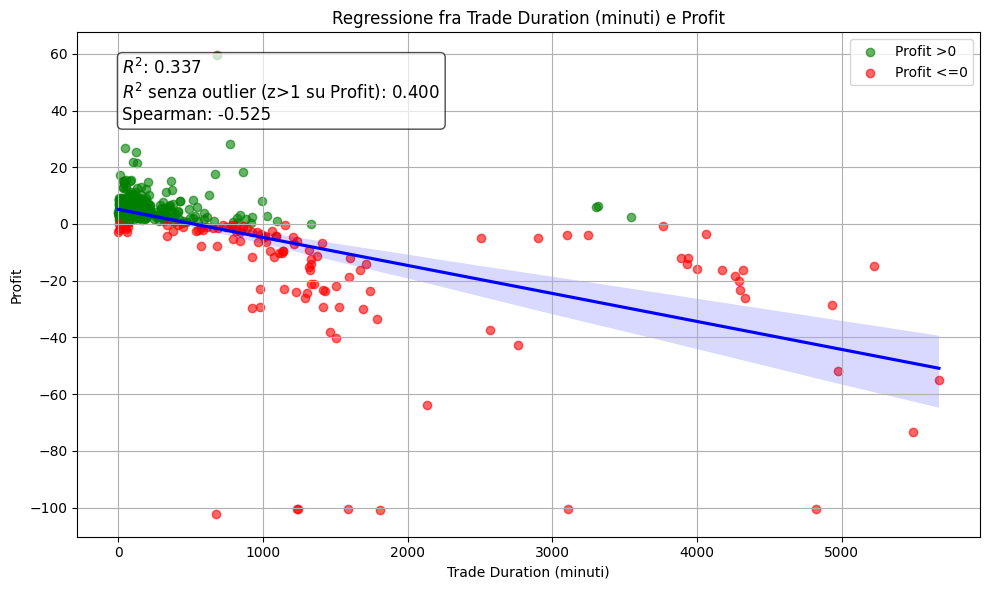

In [51]:
# 4. Profit vs Duration Analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, zscore

# Filtra solo le righe con valori validi
plot_df = df[(df['Trade_Duration'].notnull()) & (df['Profit'].notnull())].copy()

# Crea una colonna colore: verde se profit > 0, rosso se <= 0
plot_df['color'] = plot_df['Profit'].apply(lambda x: 'green' if x > 0 else 'red')

# Calcola R2 della regressione lineare
X = plot_df['Trade_Duration'].values.reshape(-1, 1)
y = plot_df['Profit'].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)

# Calcola coefficiente di correlazione di Spearman
spearman_corr, spearman_p = spearmanr(plot_df['Trade_Duration'], plot_df['Profit'])

# Calcola R2 senza outlier (usando z_threshold solo su Profit)
plot_df['z_profit'] = zscore(plot_df['Profit'])
no_outliers = plot_df[plot_df['z_profit'].abs() <= z_threshold]
X_no = no_outliers['Trade_Duration'].values.reshape(-1, 1)
y_no = no_outliers['Profit'].values
reg_no = LinearRegression().fit(X_no, y_no)
y_pred_no = reg_no.predict(X_no)
r2_no = r2_score(y_no, y_pred_no)

plt.figure(figsize=(10, 6))
# Scatter colorato manualmente
for color in ['green', 'red']:
    subset = plot_df[plot_df['color'] == color]
    plt.scatter(subset['Trade_Duration'], subset['Profit'], c=color, label=f'Profit {">0" if color=="green" else "<=0"}', alpha=0.6)
# Linea di regressione (senza colore dei punti)
sns.regplot(x='Trade_Duration', y='Profit', data=plot_df, scatter=False, line_kws={'color':'blue', 'label':'Regressione'})
plt.title('Regressione fra Trade Duration (minuti) e Profit')
plt.xlabel('Trade Duration (minuti)')
plt.ylabel('Profit')
# Mostra R2 e Spearman sul grafico
plt.text(0.05, 0.95, f'$R^2$: {r2:.3f}\n$R^2$ senza outlier (z>{z_threshold} su Profit): {r2_no:.3f}\nSpearman: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_9478/3059210256.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], inner='quartile', palette='Set2')


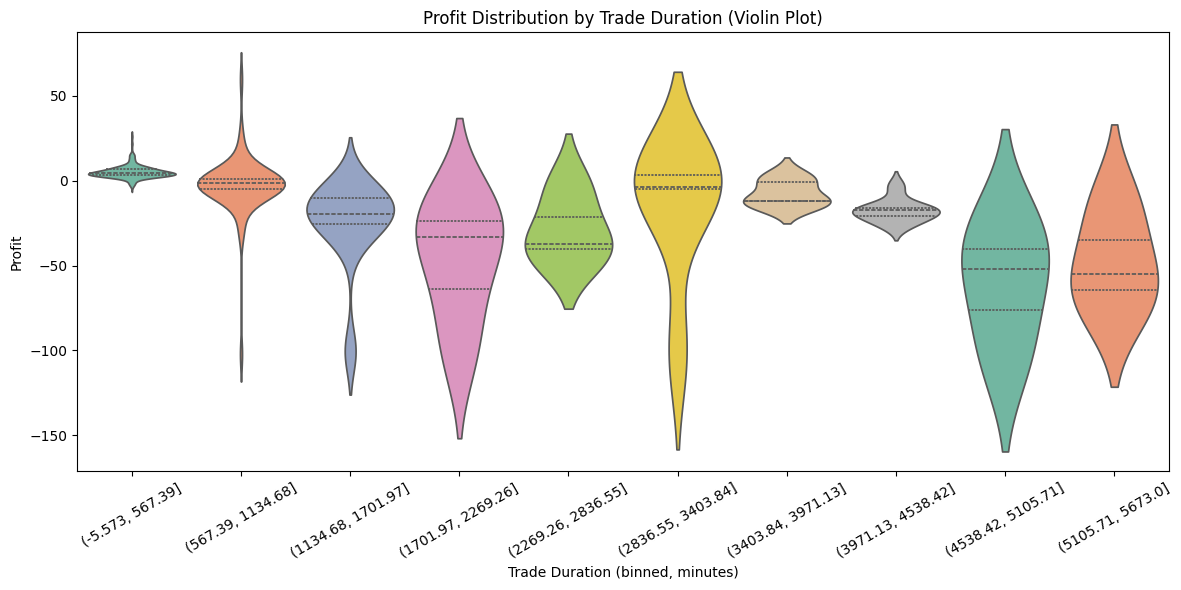

/tmp/ipykernel_9478/3059210256.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], palette='Set3')


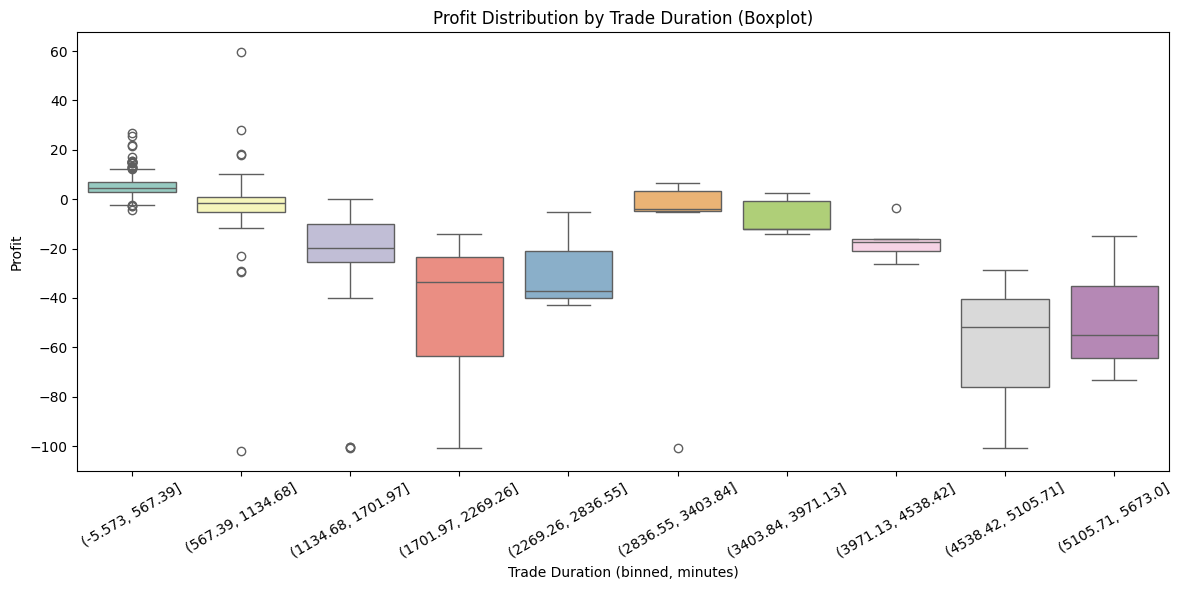

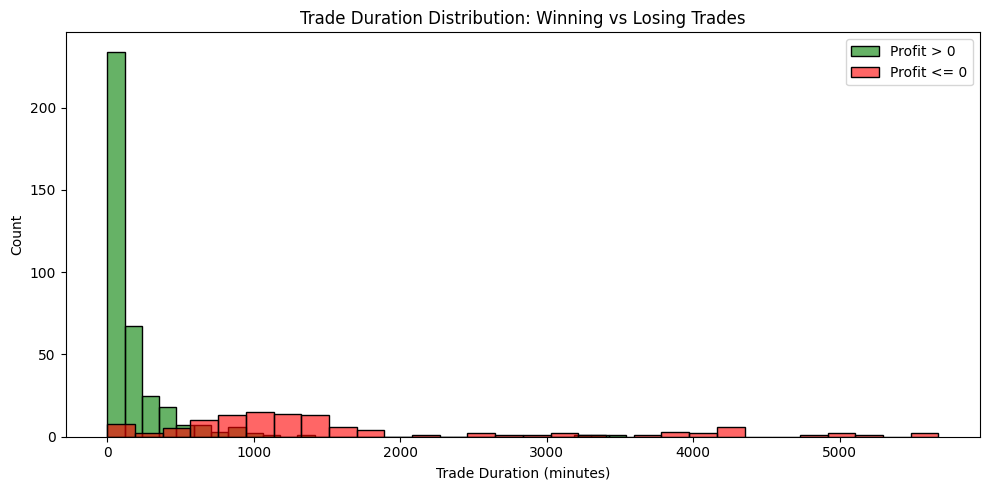

In [52]:
# 5. Profit Distribution by Duration

# Violin plot: Profit distribution by binned trade duration
plt.figure(figsize=(12, 6))
sns.violinplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], inner='quartile', palette='Set2')
plt.title('Profit Distribution by Trade Duration (Violin Plot)')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Profit')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Boxplot: Profit by binned trade duration
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(plot_df['Trade_Duration'], bins=10), y=plot_df['Profit'], palette='Set3')
plt.title('Profit Distribution by Trade Duration (Boxplot)')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Profit')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Histogram: Trade duration for winning vs losing trades
plt.figure(figsize=(10, 5))
sns.histplot(plot_df[plot_df['Profit'] > 0]['Trade_Duration'], bins=30, color='green', label='Profit > 0', alpha=0.6)
sns.histplot(plot_df[plot_df['Profit'] <= 0]['Trade_Duration'], bins=30, color='red', label='Profit <= 0', alpha=0.6)
plt.title('Trade Duration Distribution: Winning vs Losing Trades')
plt.xlabel('Trade Duration (minutes)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_9478/4292350902.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
/tmp/ipykernel_9478/4292350902.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())


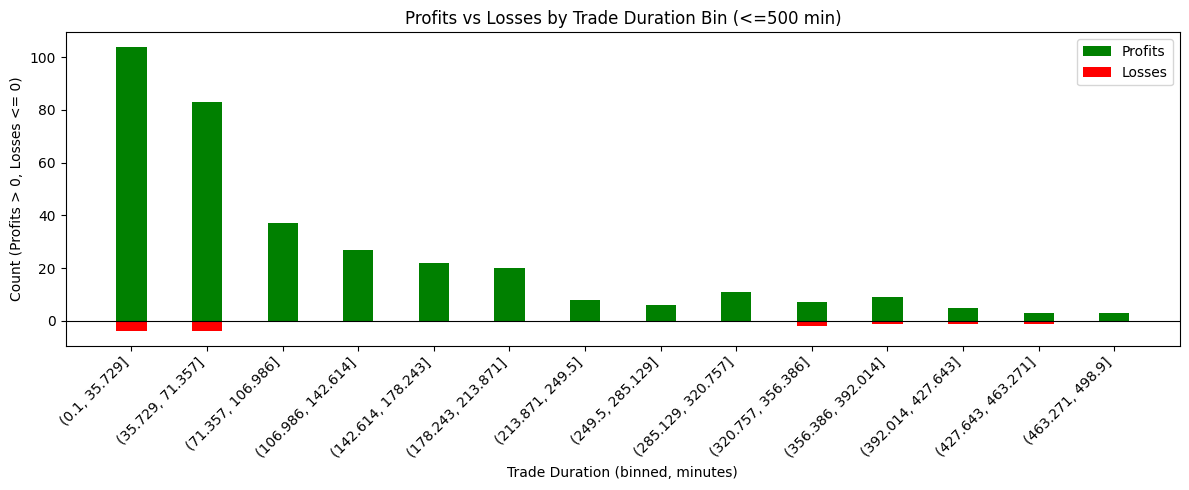

In [53]:
# 7. Profits/Losses by Duration Bin (<=500min)

# Profit/Loss distribution for trades with duration <= 500 minutes
import numpy as np

max_duration = 500
plot_df_500 = plot_df[plot_df['Trade_Duration'] <= max_duration].copy()

# Bin trade durations
bins_500 = np.linspace(plot_df_500['Trade_Duration'].min(), plot_df_500['Trade_Duration'].max(), 15)
plot_df_500['duration_bin'] = pd.cut(plot_df_500['Trade_Duration'], bins_500)

# Count profits and losses per bin
profit_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
loss_counts_500 = plot_df_500.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())

# Bar plot: Profits vs Losses by trade duration bin (<=500 min)
plt.figure(figsize=(12, 5))
width = 0.4
plt.bar(profit_counts_500.index.astype(str), profit_counts_500.values, width=width, label='Profits', color='green', align='center')
plt.bar(loss_counts_500.index.astype(str), -loss_counts_500.values, width=width, label='Losses', color='red', align='center')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Count (Profits > 0, Losses <= 0)')
plt.title('Profits vs Losses by Trade Duration Bin (<=500 min)')
plt.legend()
plt.tight_layout()
plt.show()

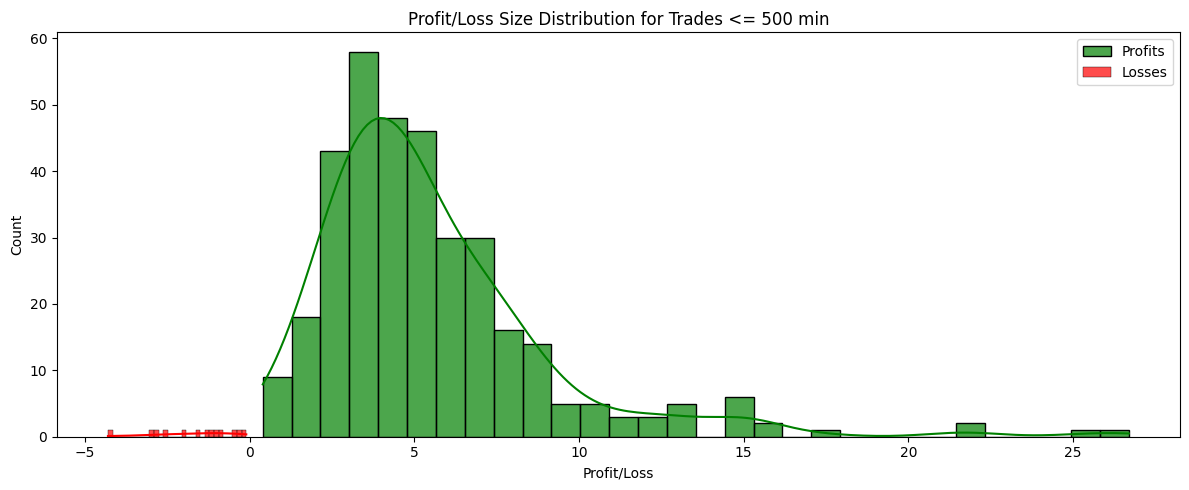

In [54]:
# 8. Profit/Loss Size Distribution (<=500min)

# Distribuzione della grandezza dei profitti e delle perdite per trade <= 500 minuti
plt.figure(figsize=(12, 5))
sns.histplot(plot_df_500[plot_df_500['Profit'] > 0]['Profit'], bins=30, color='green', label='Profits', alpha=0.7, kde=True)
sns.histplot(plot_df_500[plot_df_500['Profit'] <= 0]['Profit'], bins=30, color='red', label='Losses', alpha=0.7, kde=True)
plt.title('Profit/Loss Size Distribution for Trades <= 500 min')
plt.xlabel('Profit/Loss')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_9478/3772849723.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
/tmp/ipykernel_9478/3772849723.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())


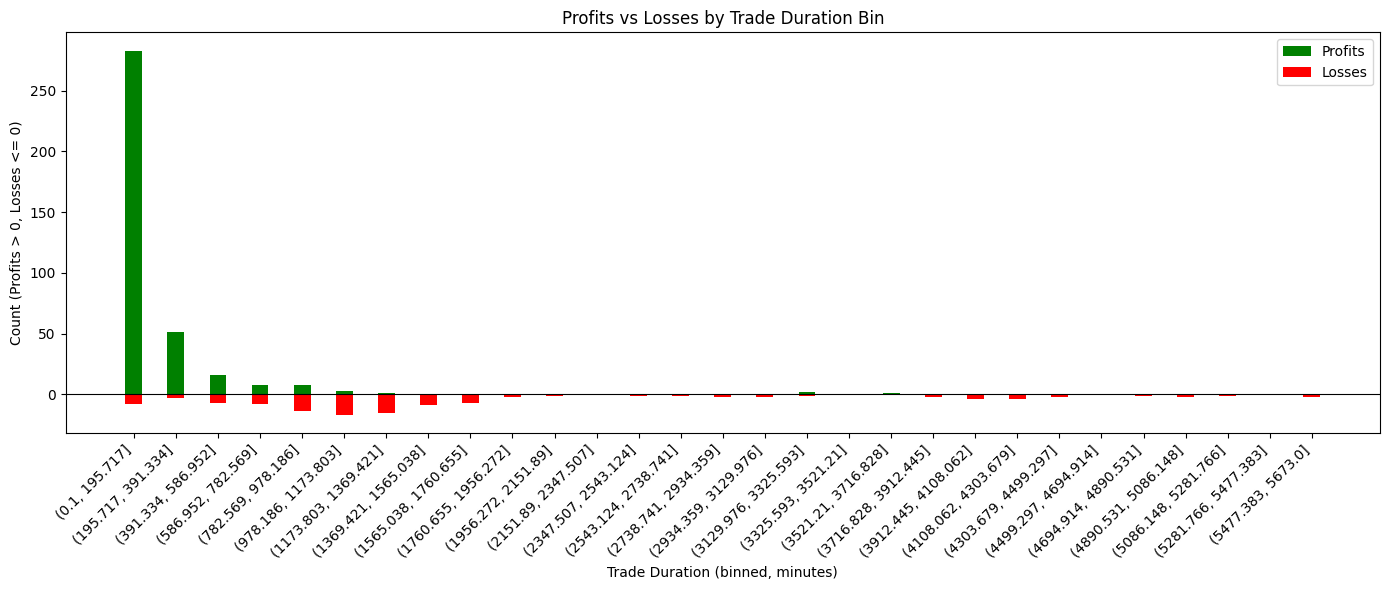

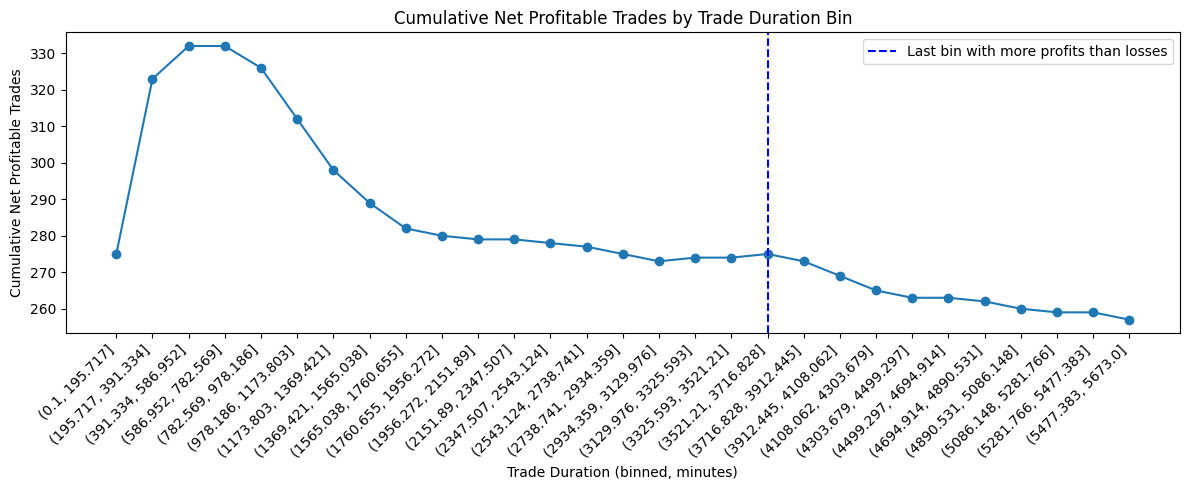

More profits than losses up to trade duration: 3716.8 minutes


In [55]:
# 6. Profits/Losses by Duration Bin

import numpy as np

# Bin trade durations
bins = np.linspace(plot_df['Trade_Duration'].min(), plot_df['Trade_Duration'].max(), 30)
plot_df['duration_bin'] = pd.cut(plot_df['Trade_Duration'], bins)

# Count profits and losses per bin
profit_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x > 0).sum())
loss_counts = plot_df.groupby('duration_bin')['Profit'].apply(lambda x: (x <= 0).sum())

# Calculate difference
diff_counts = profit_counts - loss_counts

# Find the last bin where profits > losses
last_profitable_bin = diff_counts[diff_counts > 0].index[-1] if (diff_counts > 0).any() else None

# Bar plot: Profits vs Losses by trade duration bin
plt.figure(figsize=(14, 6))
width = 0.4
plt.bar(profit_counts.index.astype(str), profit_counts.values, width=width, label='Profits', color='green', align='center')
plt.bar(loss_counts.index.astype(str), -loss_counts.values, width=width, label='Losses', color='red', align='center')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Count (Profits > 0, Losses <= 0)')
plt.title('Profits vs Losses by Trade Duration Bin')
plt.legend()
plt.tight_layout()
plt.show()

# Cumulative sum: net number of profitable trades as duration increases
cum_net = (profit_counts - loss_counts).cumsum()
plt.figure(figsize=(12, 5))
plt.plot(cum_net.index.astype(str), cum_net.values, marker='o')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Trade Duration (binned, minutes)')
plt.ylabel('Cumulative Net Profitable Trades')
plt.title('Cumulative Net Profitable Trades by Trade Duration Bin')
if last_profitable_bin is not None:
    plt.axvline(str(last_profitable_bin), color='blue', linestyle='--', label=f'Last bin with more profits than losses')
    plt.legend()
plt.tight_layout()
plt.show()

# Print the upper bound of the last profitable bin
if last_profitable_bin is not None:
    print(f"More profits than losses up to trade duration: {last_profitable_bin.right:.1f} minutes")
else:
    print('No duration bin with more profits than losses.')

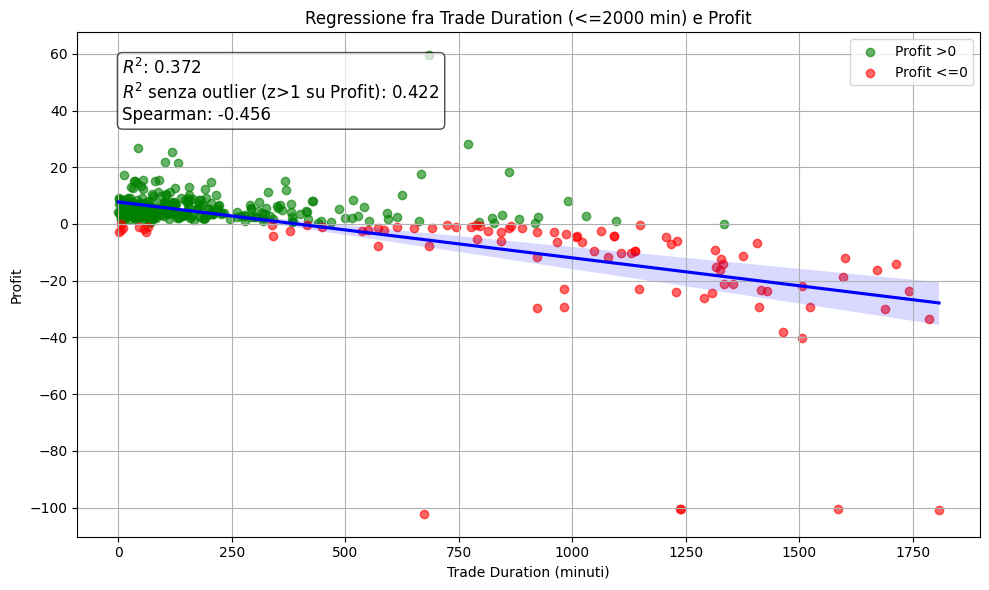

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, zscore

# Filtra solo le righe con valori validi e durata <= 2000 minuti
plot_df_short = df[(df['Trade_Duration'].notnull()) & (df['Profit'].notnull()) & (df['Trade_Duration'] <= 2000)].copy()

# Crea una colonna colore: verde se profit > 0, rosso se <= 0
plot_df_short['color'] = plot_df_short['Profit'].apply(lambda x: 'green' if x > 0 else 'red')

# Calcola R2 della regressione lineare
X = plot_df_short['Trade_Duration'].values.reshape(-1, 1)
y = plot_df_short['Profit'].values
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2 = r2_score(y, y_pred)

# Calcola coefficiente di correlazione di Spearman
spearman_corr, spearman_p = spearmanr(plot_df_short['Trade_Duration'], plot_df_short['Profit'])

# Calcola R2 senza outlier (usando z_threshold solo su Profit)
plot_df_short['z_profit'] = zscore(plot_df_short['Profit'])
no_outliers = plot_df_short[plot_df_short['z_profit'].abs() <= z_threshold]
X_no = no_outliers['Trade_Duration'].values.reshape(-1, 1)
y_no = no_outliers['Profit'].values
reg_no = LinearRegression().fit(X_no, y_no)
y_pred_no = reg_no.predict(X_no)
r2_no = r2_score(y_no, y_pred_no)

plt.figure(figsize=(10, 6))
# Scatter colorato manualmente
for color in ['green', 'red']:
    subset = plot_df_short[plot_df_short['color'] == color]
    plt.scatter(subset['Trade_Duration'], subset['Profit'], c=color, label=f'Profit {">0" if color=="green" else "<=0"}', alpha=0.6)
# Linea di regressione (senza colore dei punti)
sns.regplot(x='Trade_Duration', y='Profit', data=plot_df_short, scatter=False, line_kws={'color':'blue', 'label':'Regressione'})
plt.title('Regressione fra Trade Duration (<=2000 min) e Profit')
plt.xlabel('Trade Duration (minuti)')
plt.ylabel('Profit')
# Mostra R2 e Spearman sul grafico
plt.text(0.05, 0.95, f'$R^2$: {r2:.3f}\n$R^2$ senza outlier (z>{z_threshold} su Profit): {r2_no:.3f}\nSpearman: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()